In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nitishpandey04","key":"25e697bcb9f519cb2af5d5a7c19f2874"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

 98% 796M/812M [00:03<00:00, 236MB/s]
100% 812M/812M [00:03<00:00, 229MB/s]


In [5]:
!unzip -qq dogs-vs-cats.zip

In [6]:
!unzip -qq train.zip

In [7]:
import os, shutil, pathlib

In [8]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

In [9]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [12]:
conv_base = keras.applications.vgg16.VGG16(include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [13]:
conv_base.trainable = False

In [14]:
data_augmentation = keras.Sequential([
                                      layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.2)
])

In [15]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [16]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                             

In [18]:
callbacks = [
             keras.callbacks.ModelCheckpoint(filepath="FE_with_DA.keras",
                                             monitor="val_loss",
                                             save_best_only=True)
]

In [19]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 38s 370ms/step - loss: 18.9510 - accuracy: 0.8905 - val_loss: 9.0020 - val_accuracy: 0.9490
Epoch 2/50
63/63 [==============================] - 21s 333ms/step - loss: 6.9467 - accuracy: 0.9435 - val_loss: 5.4329 - val_accuracy: 0.9670
Epoch 3/50
63/63 [==============================] - 21s 333ms/step - loss: 6.2283 - accuracy: 0.9580 - val_loss: 5.1845 - val_accuracy: 0.9770
Epoch 4/50
63/63 [==============================] - 21s 328ms/step - loss: 4.2697 - accuracy: 0.9645 - val_loss: 5.8020 - val_accuracy: 0.9660
Epoch 5/50
63/63 [==============================] - 21s 335ms/step - loss: 6.0646 - accuracy: 0.9565 - val_loss: 3.3079 - val_accuracy: 0.9790
Epoch 6/50
63/63 [==============================] - 21s 331ms/step - loss: 4.2528 - accuracy: 0.9660 - val_loss: 2.4622 - val_accuracy: 0.9800
Epoch 7/50
63/63 [==============================] - 21s 327ms/step - loss: 2.6734 - accuracy: 0.9740 - val_loss: 4.3456 - val_accuracy: 0.975

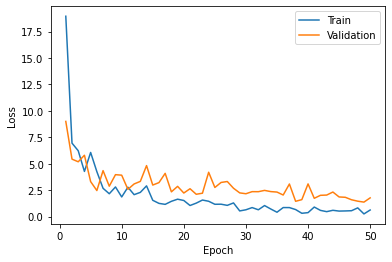

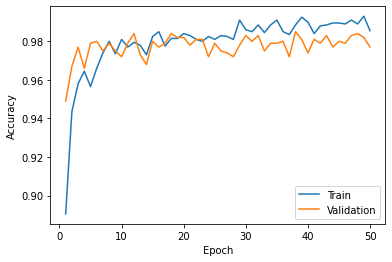

In [20]:
plt.plot(range(1, 51), history.history["loss"], label="Train")
plt.plot(range(1, 51), history.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.figure()
plt.plot(range(1, 51), history.history["accuracy"], label="Train")
plt.plot(range(1, 51), history.history["val_accuracy"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [21]:
model.evaluate(test_dataset)

63/63 [==============================] - 13s 207ms/step - loss: 2.9986 - accuracy: 0.9745


[2.9985883235931396, 0.9745000004768372]

The accuracy on the test set is 97.45% which is less than what we achieved without data augmentation.